In [1]:
from standard_libs import *

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [3]:
from ml_editor.data_processing import (
    format_raw_df,
    get_split_by_author
)

from ml_editor.model_v2 import (
    add_char_count_features,
    get_word_stats,
    get_sentiment_score,
    POS_NAMES,
    get_question_score_from_input
)

from ml_editor.model_evaluation import (
    get_feature_importance,
    get_roc_plot,
    get_metrics,
    get_confusion_matrix_plot,
    get_calibration_plot
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/yl238/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
%load_ext autoreload
%autoreload 2
np.random.seed(42)

### Get data

In [5]:
data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)
df = format_raw_df(df.copy())
df = df.loc[df['is_question']].copy()

### Features

In [6]:
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")
df = add_char_count_features(df.copy())
df = get_word_stats(df.copy())
df = get_sentiment_score(df.copy())

100%|██████████| 7971/7971 [00:14<00:00, 563.46it/s]


In [7]:
feature_arr = ["num_questions", 
               "num_periods",
               "num_commas",
               "num_exclam",
               "num_quotes",
               "num_colon",
               "num_stops",
               "num_semicolon",
               "num_words",
               "num_chars",
               "num_diff_words",
               "avg_word_len",
               "polarity"
              ]
feature_arr.extend(POS_NAMES.keys())

### Model

In [8]:
train_df, test_df = get_split_by_author(df, test_size=0.2, random_state=42)
df[feature_arr].head()*100

,num_questions,num_periods,num_commas,num_exclam,num_quotes,num_colon,num_stops,num_semicolon,num_words,num_chars,...,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
Id,,,,,,,,,,,,,,,,,,,,,
1,56.818182,56.818182,28.409091,0.0,0.000000,0.0,1022.727273,0.0,2073.863636,35200,...,3.125000,0.000000,1.136364,2.272727,0.000000,1.988636,0.000000,0.000000,3.693182,0.0
2,90.634441,30.211480,60.422961,0.0,60.422961,0.0,1087.613293,0.0,2024.169184,33100,...,4.229607,0.000000,0.000000,1.510574,0.000000,2.416918,0.302115,0.000000,1.510574,0.0
3,175.438596,87.719298,87.719298,0.0,0.000000,0.0,1491.228070,0.0,2719.298246,11400,...,2.631579,0.877193,0.000000,5.263158,0.000000,3.508772,0.000000,0.000000,5.263158,0.0
5,70.257611,46.838407,117.096019,0.0,0.000000,0.0,843.091335,0.0,2154.566745,42700,...,3.747073,0.000000,1.170960,0.702576,0.000000,2.810304,0.234192,0.234192,3.512881,0.0
7,135.135135,67.567568,67.567568,0.0,0.000000,0.0,945.945946,0.0,2027.027027,14800,...,2.702703,0.000000,0.000000,2.702703,1.351351,2.702703,0.675676,0.000000,1.351351,0.0


In [9]:
def get_feature_vector_and_label(df, feature_names):
    """
    Generate input and output vectors using the vectors feature
    and the given feature names
    
    Parameters
    ----------
    df: DataFrame
        input DataFrame
    feature_names: array-like
        names of feature columns
        
    Returns
    -------
        feature array and label array
    """
    features = df[feature_names].astype(float)
    labels = df['Score'] > df['Score'].median()
    return features, labels

In [10]:
X_train, y_train = get_feature_vector_and_label(train_df, feature_arr)
X_test, y_test = get_feature_vector_and_label(test_df, feature_arr)

In [34]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True, random_state=42)
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

### Tracking performance

In [35]:
y_train_pred = np.argmax(clf.oob_decision_function_, axis=1)
accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
print("Training accuracy = {:.3f}, precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}".format(accuracy, precision, recall, f1))

Training accuracy = 0.571, precision = 0.550, recall = 0.430, f1 = 0.482


In [36]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("Testing accuracy = {:.3f}, precision = {:.3f}, recall = {:.3f}, f1 = {:.3f}".format(accuracy, precision, recall, f1))

Testing accuracy = 0.574, precision = 0.553, recall = 0.456, f1 = 0.500


In [37]:
model_path = Path("../models/model_3.pkl")
joblib.dump(clf, model_path)

['../models/model_3.pkl']

### Validating that features are useful

In [38]:
all_feature_names = np.array(feature_arr)

In [39]:
k = 20
print("Top {} importances: \n".format(k))
print("\n".join(["{}:{:.2g}".format(tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[:k]]))
print("\nBottom {} importances:\n".format(k))
print("\n".join(["{}:{:.2g}".format(tup[0], tup[1]) for tup in get_feature_importance(clf, all_feature_names)[-k:]]))

Top 20 importances: 

num_questions:0.049
num_periods:0.049
num_chars:0.049
num_diff_words:0.049
ADV:0.046
ADJ:0.046
DET:0.044
PART:0.043
num_commas:0.042
AUX:0.042
ADP:0.042
NOUN:0.041
PUNCT:0.041
polarity:0.041
VERB:0.04
PRON:0.039
num_words:0.038
num_stops:0.038
avg_word_len:0.038
SCONJ:0.037

Bottom 20 importances:

ADP:0.042
NOUN:0.041
PUNCT:0.041
polarity:0.041
VERB:0.04
PRON:0.039
num_words:0.038
num_stops:0.038
avg_word_len:0.038
SCONJ:0.037
PROPN:0.03
NUM:0.024
num_colon:0.022
num_quotes:0.019
SYM:0.014
INTJ:0.013
X:0.01
num_semicolon:0.0071
num_exclam:0.0069
CONJ:0


### Comparing predictions to data

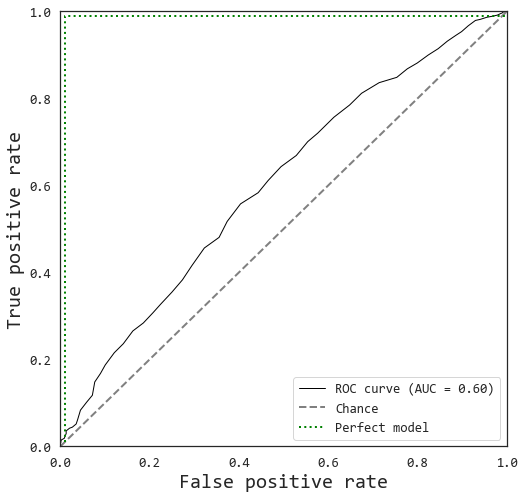

In [40]:
get_roc_plot(y_predicted_proba[:,1], y_test, figsize=(8,8))

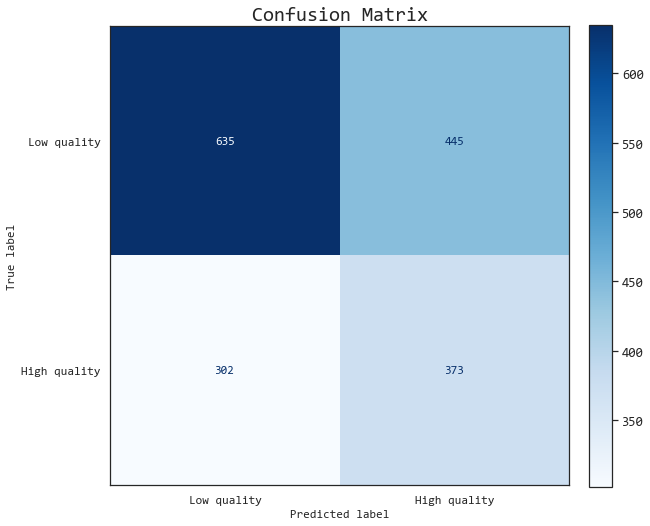

In [41]:
get_confusion_matrix_plot(y_predicted, y_test, figsize=(9, 9), values_format='d')

No handles with labels found to put in legend.


	Brier: 0.242


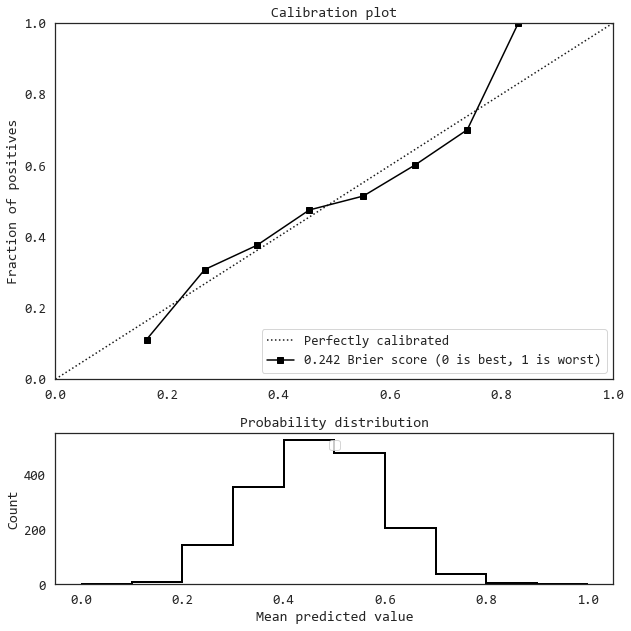

In [42]:
get_calibration_plot(y_predicted_proba[:,1], y_test, figsize=(9,9))

### Running Inference

In [20]:
pos_prob = get_question_score_from_input("""
When quoting a person's informal speech, how much liberty do you have to make changes to what they say?
""")

print("%s probability of the question receiving a high score according to our model" % (pos_prob))

100%|██████████| 1/1 [00:00<00:00, 370.39it/s]

0.39 probability of the question receiving a high score according to our model
